## DNA SEQUENCING USING MACHINE LEARNING

In [1]:
## IMPORTING NECESSARY LIBRARIRIES

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
human_data=pd.read_table("/content/human_data.txt")
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [6]:
chimp_data=pd.read_table("/content/chimp_data.txt")
chimp_data.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [7]:
dog_data=pd.read_table("/content/dog_data.txt")
dog_data.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


## Treating DNA sequence as a "language", otherwise known as k-mer counting

A challenge that remains is that none of these above methods results in vectors of uniform length, and that is a requirement for feeding data to a classification or regression algorithm. So with the above methods you have to resort to things like truncating sequences or padding with "n" or "0" to get vectors of uniform length.

DNA and protein sequences can be viewed metaphorically as the language of life. The language encodes instructions as well as function for the molecules that are found in all life forms. The sequence language analogy continues with the genome as the book, subsequences (genes and gene families) are sentences and chapters, k-mers and peptides (motifs) are words, and nucleotide bases and amino acids are the alphabet. Since the analogy seems so apt, it stands to reason that the amazing work done in the natural language processing field should also apply to the natural language of DNA and protein sequences.

The method I use here is simple and easy. I first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if I use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

Here I am using hexamer “words” but that is arbitrary and word length can be tuned to suit the particular situation. The word length and amount of overlap need to be determined empirically for any given application.

In genomics, we refer to these types of manipulations as "k-mer counting", or counting the occurances of each possible k-mer sequence. There are specialized tools for this, but the Python natural language processing tools make it supe easy.

Here is a function that can be used to convert any sequence (string) to overlapping k-mer words:


## Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string. We will basically apply the k-mers to the complete sequences.

In [8]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmer(sequence,size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence)-size+1)]

## Now we can convert our training data sequences into short overlapping k-mers of legth 6. Lets do that for each species of data we have using our getKmers function.

In [9]:
human_data['words']=human_data.apply(lambda x:getKmer(x['sequence']),axis=1)
human_data=human_data.drop('sequence',axis=1)
chimp_data['words']=chimp_data.apply(lambda x: getKmer(x['sequence']),axis=1)
chimp_data=chimp_data.drop('sequence',axis=1)
dog_data['words']=dog_data.apply(lambda x:getKmer(x['sequence']),axis=1)
dog_data=dog_data.drop('sequence',axis=1)

## Now, our coding sequence data is changed to lowercase, split up into all possible k-mer words of length 6 and ready for the next step. Let's take a look.

In [10]:
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [11]:
chimp_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,4,"[atggcc, tggcct, ggcctc, gcctcg, cctcgc, ctcgc..."
3,4,"[atggcc, tggcct, ggcctc, gcctcg, cctcgc, ctcgc..."
4,6,"[atgggc, tgggca, gggcag, ggcagc, gcagcg, cagcg..."


In [12]:
dog_data.head()

,class,words
0,4,"[atgcca, tgccac, gccaca, ccacag, cacagc, acagc..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,6,"[atggaa, tggaaa, ggaaac, gaaaca, aaacac, aacac..."
3,6,"[atgtgc, tgtgca, gtgcac, tgcact, gcacta, cacta..."
4,0,"[atgagc, tgagcc, gagccg, agccgg, gccggc, ccggc..."


## Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use. We can also make a y variable to hold the class labels. Let's do that now.

In [13]:
human_texts=list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item]=' '.join(human_texts[item])
y_data=human_data.iloc[:,0].values

In [14]:
print(human_texts[2])

atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatttc atttca tttcac ttcacc tcaccg caccgg accggt

In [15]:
y_data

array([4, 4, 3, ..., 6, 6, 6])

## We will perform the same steps for chimpanzee and dog

In [16]:
chimp_texts=list(chimp_data['words'])
for i in range(len(chimp_texts)):
    chimp_texts[i]=' '.join(chimp_texts[i])
y_chimp=chimp_data.iloc[:,0].values

In [17]:
print(chimp_texts[2])

atggcc tggcct ggcctc gcctcg cctcgc ctcgcg tcgcgc cgcgct gcgctg cgctgg gctggt ctggtg tggtgg ggtggc gtggcg tggcgg ggcggt gcggtg cggtgg ggtggc gtggcg tggcga ggcgac gcgacg cgacgc gacgcg acgcgg cgcggc gcggct cggctg ggctgc gctgct ctgctc tgctcc gctcct ctcctg tcctgg cctgga ctggag tggagg ggaggc gaggcc aggccg ggccgg gccggc ccggcg cggcgg ggcggc gcggcg cggcgc ggcgcg gcgcgg cgcgga gcggag cggagc ggagct gagctc agctcc gctccg ctccgg tccggg ccgggc cgggcc gggccc ggcccg gcccgg cccggc ccggct cggctc ggctcc gctccc ctcccc tcccca ccccag cccagg ccaggc caggcc aggccg ggccgt gccgtg ccgtgc cgtgcg gtgcgg tgcggg gcggga cgggac gggacc ggaccg gaccgt accgtc ccgtcg cgtcgg gtcggg tcgggg cggggc ggggcc gggccg ggccga gccgag ccgagc cgagcg gagcgc agcgcc gcgccg cgccgc gccgct ccgctg cgctgc gctgcc ctgccg tgccga gccgac ccgacg cgacgt gacgtc acgtcc cgtccg gtccgc tccgcg ccgcgc cgcgcg gcgcgc cgcgca gcgcag cgcagg gcaggt caggtt aggttc ggttca gttcat ttcata tcatag catagg ataggc taggcg aggcgg ggcgga gcggaa cggaag ggaagg gaaggg aaggga agggac

In [18]:
y_chimp

array([4, 4, 4, ..., 6, 3, 3])

In [19]:
dog_texts=list(dog_data['words'])
for i in range(len(dog_texts)):
    dog_texts[i]=' '.join(dog_texts[i])
y_dog=dog_data.iloc[:,0].values

In [20]:
print(dog_texts[2])

atggaa tggaaa ggaaac gaaaca aaacac aacacc acaccc caccct accctt cccttc ccttct cttcta ttctac tctacg ctacgg tacggc acggcg cggcga ggcgat gcgatg cgatga gatgag atgagg tgaggc gaggcg aggcgc ggcgct gcgctg cgctga gctgag ctgagc tgagcg gagcgg agcggc gcggcc cggcct ggcctg gcctgg cctggg ctgggc tgggcg gggcgg ggcggc gcggcg cggcgg ggcggc gcggcg cggcgt ggcgtc gcgtca cgtcag gtcagt tcagta cagtag agtagc gtagca tagcag agcagt gcagtg cagtgg agtggc gtggcg tggcgg ggcggc gcggcg cggcgg ggcggt gcggtg cggtgg ggtggt gtggta tggtag ggtagc gtagct tagctt agcttc gcttcg cttcgc ttcgcg tcgcgt cgcgtc gcgtcc cgtccc gtcccc tccccg ccccgg cccggg ccgggt cgggtc gggtcg ggtcgc gtcgcc tcgcct cgcctg gcctgt cctgtt ctgttt tgtttc gtttcc tttccc ttcccg tcccgg cccggg ccgggg cggggc ggggcg gggcgc ggcgcc gcgccc cgcccc gccccc cccccg ccccga cccgac ccgacg cgacgg gacggc acggcg cggcgg ggcggc gcggcg cggcga ggcgac gcgact cgactg gactgg actggc ctggca tggcag ggcagc gcagca cagcat agcatg gcatga catgat atgatg tgatga gatgaa atgaag tgaaga gaagaa aagaaa agaaag

In [21]:
y_dog

array([4, 4, 6, 6, 0, 6, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0,
       6, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 3, 0, 6, 0, 6, 0, 6, 0,
       6, 0, 0, 3, 3, 6, 6, 6, 6, 4, 0, 0, 4, 2, 0, 0, 0, 0, 6, 0, 6, 0,
       0, 5, 5, 6, 4, 6, 0, 0, 3, 6, 3, 6, 6, 6, 6, 6, 4, 6, 4, 1, 4, 0,
       0, 0, 6, 4, 4, 6, 6, 6, 6, 6, 4, 6, 6, 3, 3, 3, 3, 0, 6, 3, 3, 6,
       4, 4, 5, 6, 6, 1, 5, 2, 2, 1, 4, 2, 6, 3, 3, 6, 6, 6, 3, 3, 6, 6,
       6, 3, 6, 6, 2, 0, 0, 6, 6, 3, 3, 3, 0, 0, 4, 6, 6, 5, 1, 1, 0, 0,
       0, 4, 0, 4, 0, 0, 3, 4, 6, 0, 6, 6, 3, 4, 0, 6, 6, 1, 2, 2, 2, 3,
       6, 2, 2, 2, 6, 0, 0, 6, 6, 0, 0, 1, 6, 5, 5, 6, 0, 6, 0, 0, 4, 0,
       0, 3, 4, 0, 0, 6, 6, 5, 5, 3, 4, 1, 0, 6, 5, 6, 6, 4, 4, 2, 2, 2,
       4, 6, 4, 4, 2, 1, 3, 6, 0, 6, 2, 3, 0, 0, 6, 0, 6, 4, 3, 1, 1, 4,
       6, 4, 4, 6, 3, 3, 2, 2, 1, 1, 3, 3, 4, 3, 0, 3, 5, 5, 5, 5, 5, 5,
       5, 2, 2, 4, 4, 6, 4, 4, 6, 6, 6, 0, 3, 3, 4, 3, 0, 0, 6, 0, 0, 6,
       6, 1, 5, 5, 0, 0, 6, 6, 1, 1, 1, 4, 2, 2, 3,

## Now we will apply the BAG of WORDS using CountVectorizer using NLP

In [22]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing

from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(4,4))
X=cv.fit_transform(human_texts)
X_chimp=cv.fit_transform(chimp_texts)
X_dog=cv.transform(dog_texts)

In [23]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 229684)
(820, 229684)


<Axes: xlabel='class'>

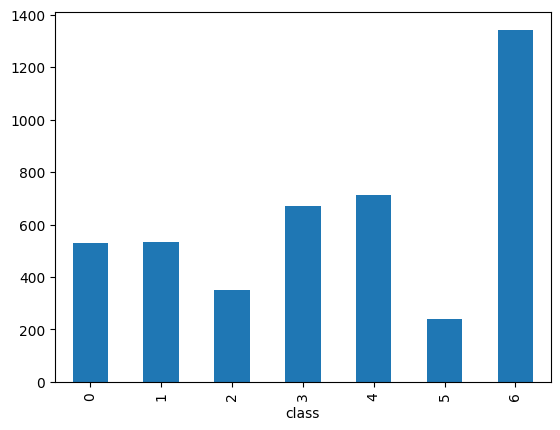

In [24]:
human_data['class'].value_counts().sort_index().plot.bar()

In [25]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y_data,test_size=0.20,random_state=20)

In [26]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


In [27]:
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression()
classifier.fit(X_train,y_train)

LogisticRegression()

In [28]:
y_pred=classifier.predict(X_test)

In [29]:
y_pred

array([6, 3, 6, 3, 3, 6, 0, 2, 4, 3, 6, 3, 4, 5, 6, 1, 4, 6, 0, 0, 2, 6,
       6, 5, 6, 1, 1, 3, 6, 2, 2, 4, 5, 6, 4, 0, 1, 6, 5, 1, 6, 3, 2, 4,
       6, 1, 1, 3, 4, 3, 5, 6, 2, 6, 1, 4, 6, 2, 5, 6, 1, 1, 1, 6, 6, 6,
       2, 3, 2, 0, 3, 4, 2, 3, 6, 6, 4, 3, 6, 0, 4, 2, 0, 5, 2, 5, 6, 6,
       5, 6, 4, 6, 3, 1, 4, 1, 3, 6, 4, 2, 6, 4, 6, 6, 6, 3, 1, 6, 6, 6,
       3, 0, 6, 6, 2, 4, 3, 4, 0, 6, 6, 2, 6, 1, 3, 3, 4, 6, 3, 2, 6, 5,
       6, 4, 4, 1, 0, 3, 1, 3, 0, 6, 3, 0, 0, 6, 6, 0, 1, 6, 6, 4, 1, 6,
       3, 6, 3, 6, 3, 6, 1, 5, 1, 4, 0, 0, 6, 6, 1, 6, 3, 4, 1, 6, 0, 5,
       6, 6, 3, 2, 1, 4, 2, 6, 3, 2, 6, 0, 3, 1, 6, 3, 6, 2, 6, 6, 1, 1,
       4, 3, 0, 6, 6, 6, 6, 0, 4, 6, 3, 6, 6, 1, 4, 0, 1, 2, 6, 2, 3, 6,
       6, 5, 6, 1, 6, 4, 6, 6, 4, 1, 4, 3, 4, 1, 6, 6, 1, 0, 2, 1, 6, 3,
       6, 4, 6, 3, 1, 3, 6, 6, 4, 4, 6, 6, 6, 4, 3, 6, 6, 0, 0, 0, 6, 0,
       6, 1, 6, 1, 1, 6, 4, 6, 0, 3, 0, 6, 4, 4, 3, 5, 4, 6, 6, 6, 1, 6,
       6, 6, 3, 6, 4, 6, 4, 6, 3, 1, 3, 3, 3, 2, 2,

In [30]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print(accuracy_score(y_pred,y_test))
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_pred,y_test))

0.9429223744292238
              precision    recall  f1-score   support

           0       0.92      0.99      0.96        87
           1       0.89      0.99      0.94        96
           2       0.97      1.00      0.98        86
           3       0.92      0.99      0.96       129
           4       0.94      0.97      0.96       119
           5       0.78      1.00      0.88        35
           6       1.00      0.86      0.93       324

    accuracy                           0.94       876
   macro avg       0.92      0.97      0.94       876
weighted avg       0.95      0.94      0.94       876

[[ 86   0   0   1   0   0   0]
 [  0  95   0   0   1   0   0]
 [  0   0  86   0   0   0   0]
 [  0   0   0 128   0   1   0]
 [  1   0   0   1 116   1   0]
 [  0   0   0   0   0  35   0]
 [  6  12   3   9   6   8 280]]


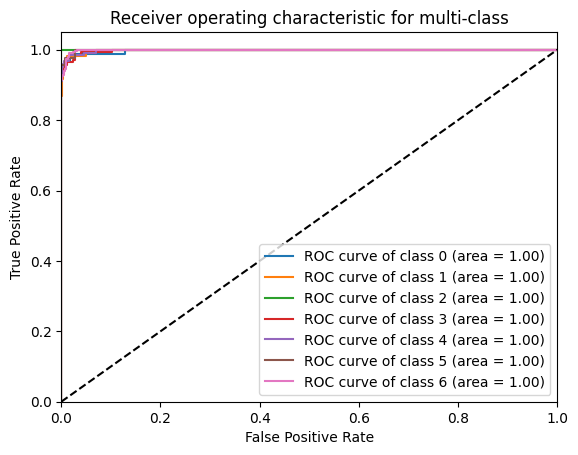

Confusion Matrix:
[[ 86   0   0   0   1   0   6]
 [  0  95   0   0   0   0  12]
 [  0   0  86   0   0   0   3]
 [  1   0   0 128   1   0   9]
 [  0   1   0   0 116   0   6]
 [  0   0   0   1   1  35   8]
 [  0   0   0   0   0   0 280]]


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Assuming 'classifier' is your trained Logistic Regression model
# and 'X_test', 'y_test' are your test data

# Predict probabilities for each class
y_prob = classifier.predict_proba(X_test)

# Binarize the true labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=classifier.classes_)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(classifier.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Optionally, you can use seaborn for a visually appealing confusion matrix
# import seaborn as sns
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
# plt.title("Confusion Matrix")
# plt.show()

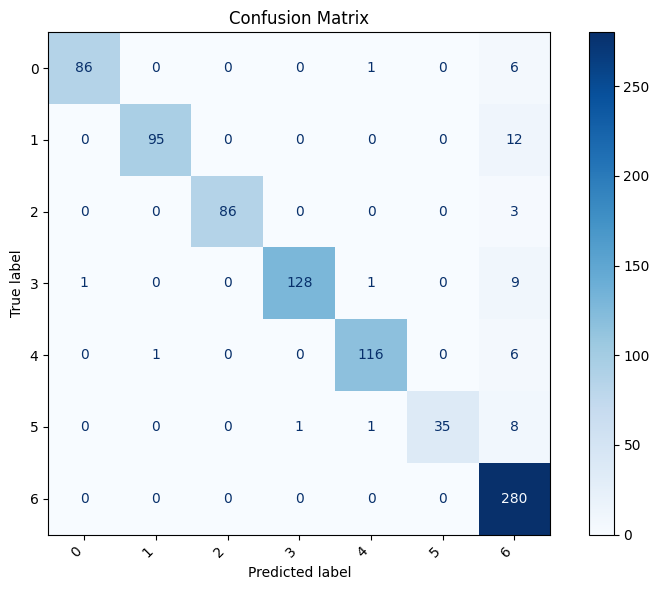

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)

# Plot confusion matrix with seaborn heatmap for better visualization
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figsize as needed
disp.plot(ax=ax, cmap='Blues', values_format='d')  # Customize cmap and values_format
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

Accuracy: 0.9863013698630136


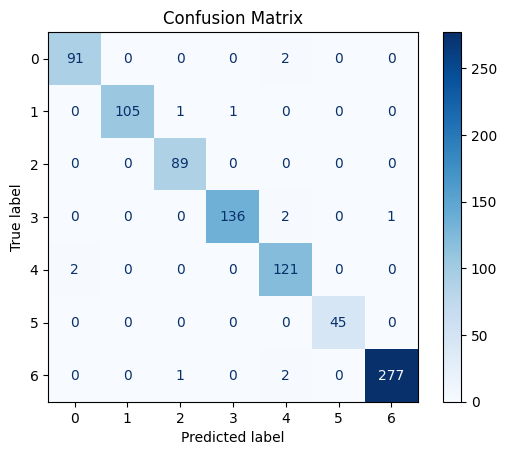

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Assuming X_train, y_train, X_test, y_test are already defined

# 1. Create a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# 2. Reorder indices of X_train if it's a csr_matrix
if isinstance(X_train, csr_matrix):
    X_train = X_train.sorted_indices()

# 3. Train the classifier
nb_classifier.fit(X_train, y_train)

# 4. Predict on the test data
y_pred = nb_classifier.predict(X_test)

# 5. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 6. Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

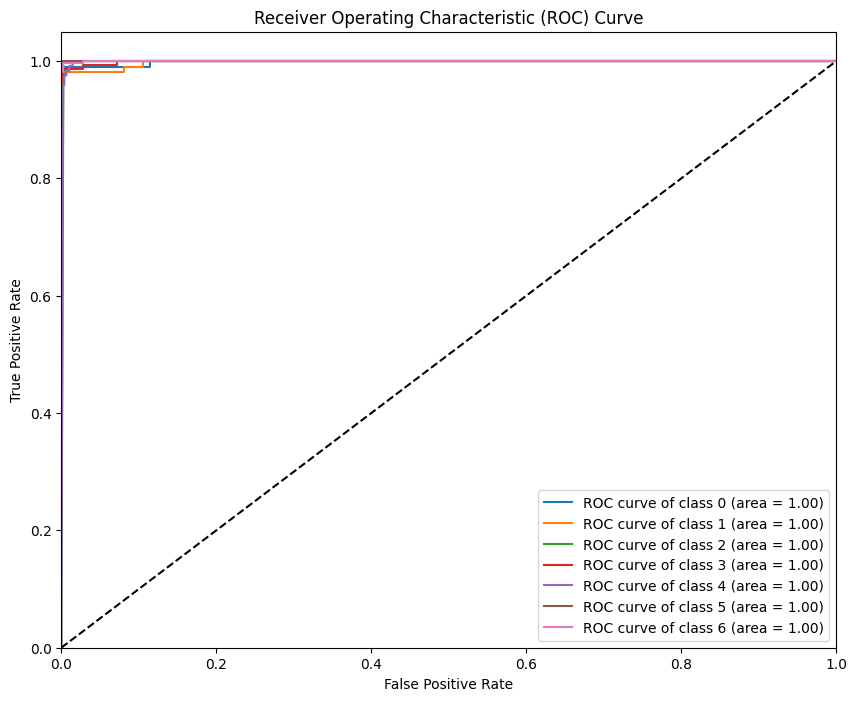

In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import numpy as np

# Assuming X_train, y_train, X_test, y_test are already defined

# 1. Create a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# 2. Reorder indices of X_train if it's a csr_matrix
if isinstance(X_train, csr_matrix):
    X_train = X_train.sorted_indices()

# 3. Train the classifier
nb_classifier.fit(X_train, y_train)

# 4. Predict probabilities on the test data
y_prob = nb_classifier.predict_proba(X_test)

# 5. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(nb_classifier.classes_)  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(
        (y_test == nb_classifier.classes_[i]).astype(int), y_prob[:, i]
    )
    roc_auc[i] = auc(fpr[i], tpr[i])

# 6. Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label="ROC curve of class {0} (area = {1:0.2f})".format(
            nb_classifier.classes_[i], roc_auc[i]
        ),
    )

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.sparse import csr_matrix

input_size = X_train.shape[1]

# Build the model
model = models.Sequential()

# Input layer and first hidden layer, with the correct input_size
model.add(layers.Dense(512, activation='relu', input_shape=(input_size,)))

# Second hidden layer
model.add(layers.Dense(256, activation='relu'))

# Output layer - changed for multi-class classification
output_size = 7  # Number of classes
model.add(layers.Dense(output_size, activation='softmax'))

# Compile the model with categorical_crossentropy loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Convert target labels to one-hot encoded format
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)

# Reorder indices of X_train if it's a csr_matrix
if isinstance(X_train, csr_matrix):
    X_train = X_train.sorted_indices()

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=2, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 512)                 │     118,996,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,129,607 (454.44 MB)

 Trainable params: 119,129,607 (454.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 736ms/step - accuracy: 0.7234 - loss: 0.8645
Epoch 2/2
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 724ms/step - accuracy: 0.9997 - loss: 0.0066
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 393ms/step - accuracy: 0.9644 - loss: 0.1045
Test Loss: 0.09043245762586594
Test Accuracy: 0.97374427318573


In [36]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels
y_true_classes = np.argmax(y_test_encoded, axis=1)  # Get true class labels
# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Print accuracy
print("Accuracy:", accuracy)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.973744292237443


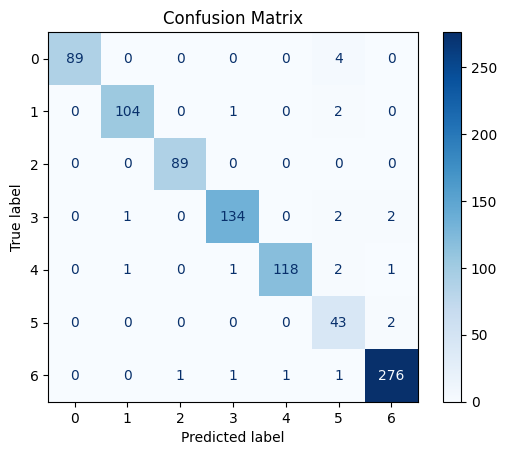

In [37]:
# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


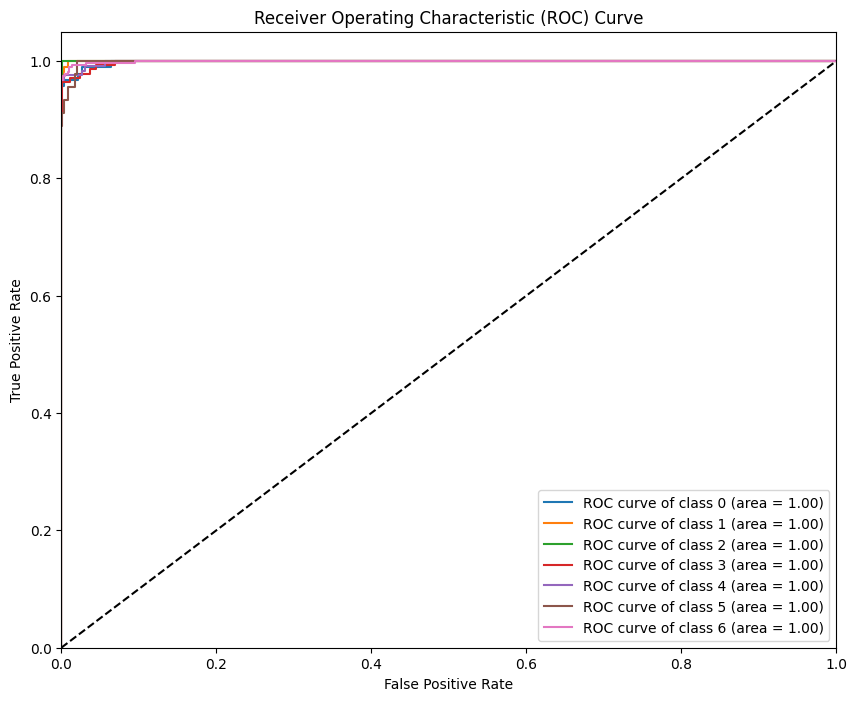

In [40]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# ... (Your existing code for model building, training, and evaluation) ...

# Predict on the test data
y_pred = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_encoded.shape[1]  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()